In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import metodos

# %matplotlib ipympl
plt.style.use('./figuras.mplstyle')

## Analisis principal

### Leer datos

In [2]:
clase = 2
duracion = 30
fs = 2500
n_medicion = 2


df = pd.read_csv(f'./Mediciones/Clase {clase}/dinamico_d{duracion}_fs{fs}({n_medicion}).csv')

V = df['Tension fotodiodo [V]'].values
tiempo = df['Tiempo [s]'].values
datos_hasta_t = df['Datos hasta tiempo'].values
duracion = df['Duracion [s]'][0]
fs = df['Frecuencia de sampleo [Hz]'][0]

t = np.arange(0, len(V)/fs + fs, fs)


N_puntos = int(duracion*fs)
Deltat = 1/fs

### Graficar señal

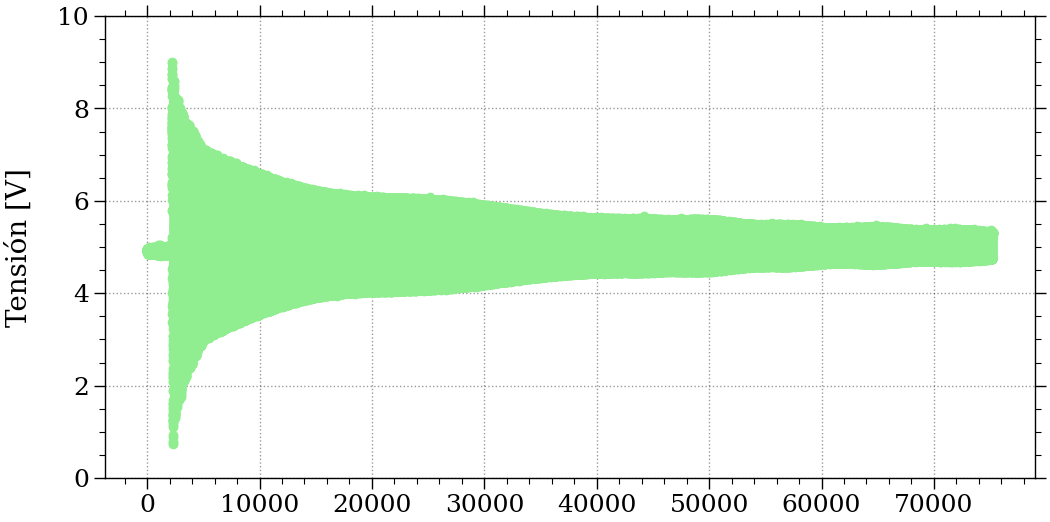

In [3]:
fig, ax = plt.subplots()
ax.set_ylabel('Tensión [V]')
ax.set_ylim((0, 10))
ax.set_xlim((0, 10000))

ax.plot(V, 'o-')

plt.show()

### FFT y sus picos

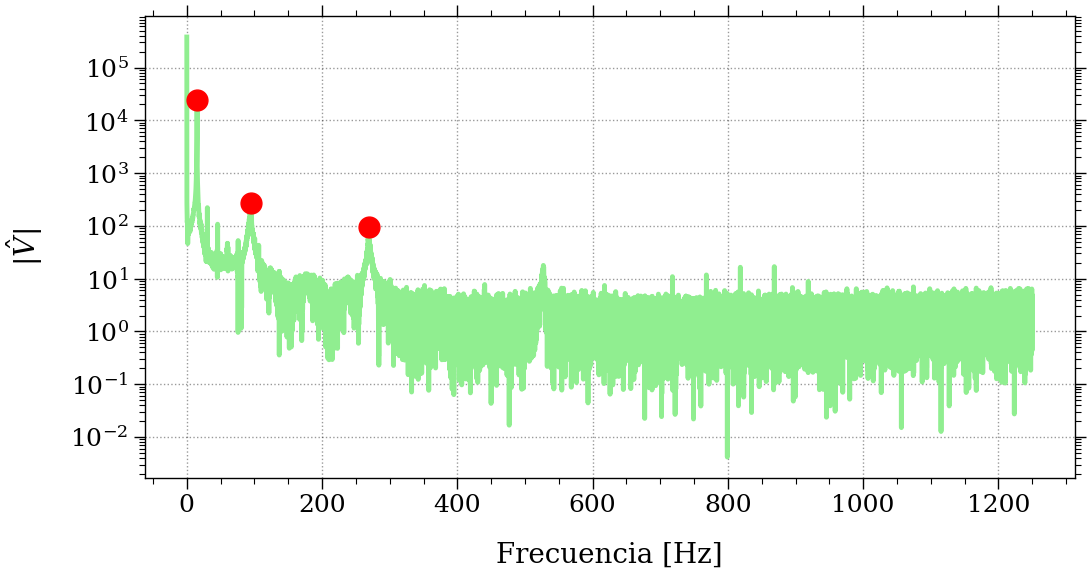

In [4]:
frecuencias = fftfreq(N_puntos, Deltat)[:N_puntos//2]
amplitudes = np.abs(fft(V)[:N_puntos//2])


peaks = find_peaks(amplitudes, threshold=1, height=10, distance=2200)[0]
peaks = [peaks[0], peaks[1], peaks[3]]


fig, ax = plt.subplots()
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel(r'$|\hat V|$')
ax.set_yscale('log')

ax.plot(frecuencias, amplitudes)
ax.plot(frecuencias[peaks], amplitudes[peaks], 'ro', ms=15)

plt.show()

### Cuenta del modulo de Young

In [5]:
import sympy as sp

d, E, k, l, alpha, f, L, M = sp.symbols(r'd E k_n l \alpha f L M')

I = sp.pi*d**4/64
m = M*l/L
rho = m/l
K_n = k/l
omega = 2*sp.pi*f

eq_omega = sp.sqrt((I*E*K_n**4) / rho - alpha**2)

eq = sp.Eq(omega, eq_omega)
sp.solve(eq, E)

[64*M*l**4*(\alpha**2 + 4*pi**2*f**2)/(pi*L*d**4*k_n**4)]

In [15]:
l = 39.5 * 1e-2 # m
sigma_l = 0.1/4 * 1e-2 # m

L = 43 * 1e-2  # m
sigma_L = 0.1/4 * 1e-2  # m

k_n = np.array([1.875, 4.694, 7.855])
sigma_k_n = np.array([0]*3)

M = 82.9345 * 1e-3  # kg
sigma_M = 0.0001 * 1e-3  # kg

d = 5.1 * 1e-3  # m
sigma_d = 0.1/4 * 1e-3 # m

f = frecuencias[peaks]  # Hz
sigma_f = np.array([np.sqrt((np.mean(np.diff(frecuencias)) / 2)**2 + (1/fs)**2)]*3)  # Hz

alpha = 0  # rad/s
sigma_alpha = 0  # rad/s

def Young(f, alpha, M, L, l, d, k_n):
    return 64*M*l**4*(alpha**2 + 4*np.pi**2*f**2)/(np.pi*L*d**4*k_n**4)

for i in range(len(f)):
    valores = [f[i], alpha, M, L, l, d, k_n[i]]
    errores = [sigma_f[i], sigma_alpha, sigma_M, sigma_L, sigma_l, sigma_d, sigma_k_n[i]]
    
    print(f'Modo {i}')
    print(f'E = {Young(f[i], alpha, M, L, l, d, k_n[i]) * 1e-9:.3f} GPa')
    print(f'sigma_E = {metodos.corr_propagation(Young, valores, errores) * 1e-9:.3f} GPa \n')

Modo 0
E = 104.339 GPa
sigma_E = 409.535 GPa 

Modo 1
E = 104.931 GPa
sigma_E = 411.853 GPa 

Modo 2
E = 106.066 GPa
sigma_E = 416.310 GPa 



In [7]:
# Errores relativos

valores = [f, M, L, l, d]
errores = [sigma_f, sigma_M, sigma_L, sigma_l, sigma_d]

for val, sigma in zip(valores, errores):
    print(sigma / val)

[1.09680697e-03 1.74509414e-04 6.19833907e-05]
1.205770819140406e-06
0.0005813953488372093
0.0006329113924050633
0.002450980392156863


## Analisis secundario

### Espectrograma

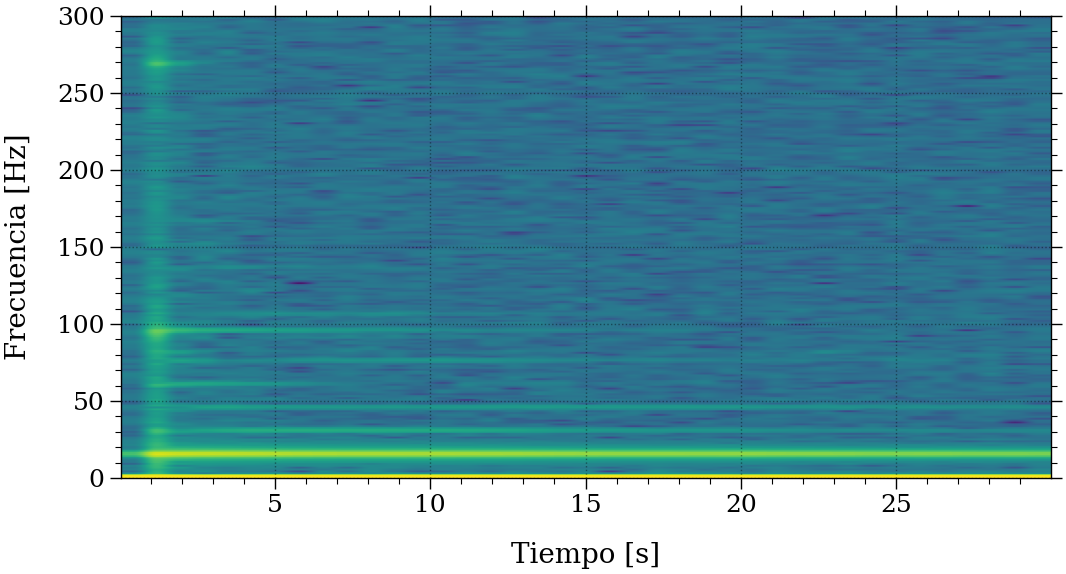

In [8]:
fig, ax = plt.subplots()
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Frecuencia [Hz]')

ax.specgram(V, NFFT= 2048, Fs=fs)




# ax.set_xlim((0, 30))
ax.set_ylim((0, 300))
plt.show()

### Cortar señal

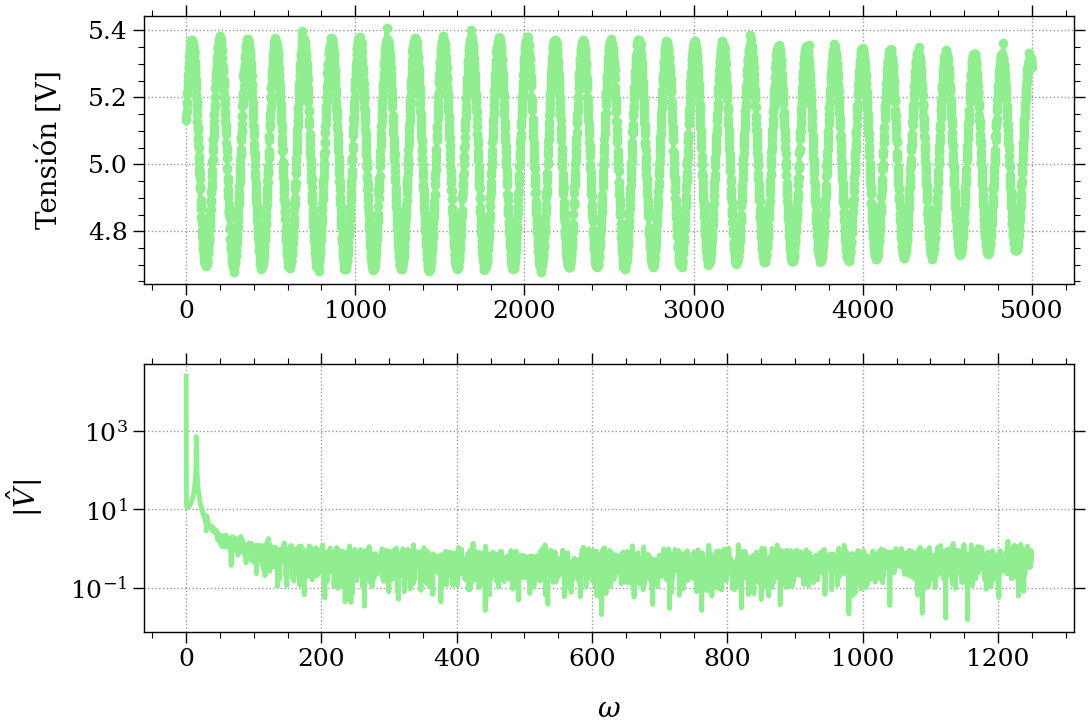

In [9]:
V_lim = V[-5000:]

frecuencia_lim = fftfreq(len(V_lim), Deltat)[:len(V_lim)//2]
amplitudes_lim = np.abs(fft(V_lim)[:len(V_lim)//2])


fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].set_ylabel('Tensión [V]')
ax[1].set_xlabel(r'$\omega$')
ax[1].set_ylabel(r'$|\hat V|$')
ax[1].set_yscale('log')

ax[0].plot(V_lim, 'o-')
ax[1].plot(frecuencia_lim, amplitudes_lim)

fig.subplots_adjust(hspace=.3)
plt.show()